In [ ]:
#import stuff we'll use
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

GET DATA

In [ ]:
# get the data set, - make sure it's imported in the right directory
data = pd.read_csv("listings.csv")
data.columns
# data[[col for col in data.columns if "review" in col]].head(10)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

CLEANING

In [ ]:
# Ensure only rows with non-missing values in the specified columns are kept
data = data.dropna(subset=["price", "host_is_superhost", "beds", "bedrooms", "bathrooms"])

# Step 3: Select relevant columns for analysis and create a copy of the data
bnb_data = data[
    [
        "host_is_superhost",
        "neighbourhood_group_cleansed",
        "room_type",
        "accommodates",
        "bathrooms",
        "bedrooms",
        "beds",
        "amenities",
        "latitude",
        "longitude",
        "price",
        "number_of_reviews",
        "first_review",
        "last_review",
        "reviews_per_month",
        "review_scores_rating",
        "availability_365",
        "id"
    ]
].copy()

# Transform "amenities" column to count the number of amenities for each listing
bnb_data["amenities"] = bnb_data["amenities"].apply(lambda x: len(x.split(",")))

# Create a new feature combining "room_type" and "neighbourhood_group_cleansed"
bnb_data["room_neighborhood_interaction"] = bnb_data["room_type"] + "_" + bnb_data["neighbourhood_group_cleansed"]

# Calculate bedroom density (number of bedrooms per accommodate capacity)
bnb_data["bedroom_density"] = bnb_data["bedrooms"] / bnb_data["accommodates"]

# Calculate the age of the listing based on the time between the first and last reviews
bnb_data["age"] = (pd.to_datetime(bnb_data["last_review"]) - pd.to_datetime(bnb_data["first_review"])).dt.days

# Drop rows with missing values in the "age" column
bnb_data = bnb_data.dropna(subset=["age"])

# Step 5: Drop unused columns
bnb_data = bnb_data.drop(["room_type", "neighbourhood_group_cleansed", "first_review", "last_review"], axis=1)

# Step 6: Encode categorical variables
# Encode "host_is_superhost" as 0 and 1
superhost_le = LabelEncoder()
bnb_data["host_is_superhost"] = superhost_le.fit_transform(bnb_data["host_is_superhost"])

# Encode "room_neighborhood_interaction" as integer labels
room_le = LabelEncoder()
bnb_data["room_neighborhood_interaction"] = room_le.fit_transform(bnb_data["room_neighborhood_interaction"])

# Display the first few rows of the processed DataFrame
bnb_data.head()

,host_is_superhost,accommodates,bathrooms,bedrooms,beds,amenities,latitude,longitude,price,number_of_reviews,reviews_per_month,review_scores_rating,availability_365,id,room_neighborhood_interaction,bedroom_density,age
0,0,8,2.0,3.0,6.0,23,41.405560,2.17262,$194.00,42,0.31,4.37,72,18674,1,0.375000,4025.0
1,1,5,2.0,3.0,4.0,54,41.412432,2.21975,$304.00,79,0.48,4.79,116,23197,7,0.600000,4850.0
2,0,6,1.5,2.0,3.0,36,41.405660,2.17015,$211.00,128,0.80,4.46,319,32711,2,0.333333,4799.0
3,0,2,1.0,1.0,1.0,32,41.380620,2.17517,$300.00,20,0.12,4.47,69,34241,0,0.500000,5155.0
4,0,9,3.0,4.0,6.0,40,41.379780,2.17623,$314.00,247,1.46,4.53,241,34981,0,0.444444,5083.0


PRICE CLEANING

In [ ]:
# Remove "$" and "," from the price column and convert it to float
bnb_data["price"] = bnb_data["price"].str.replace("$", "").str.replace(",", "").astype(float)

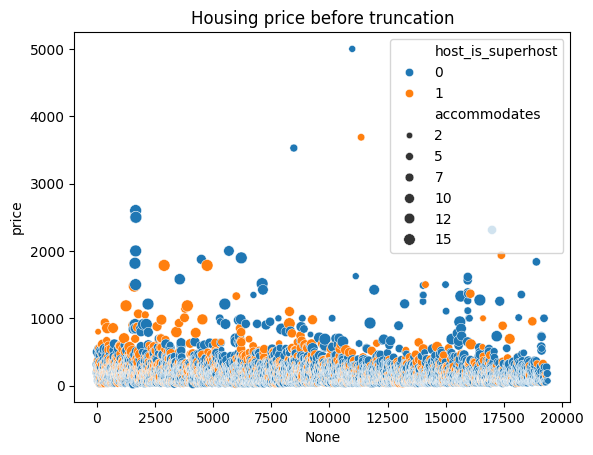

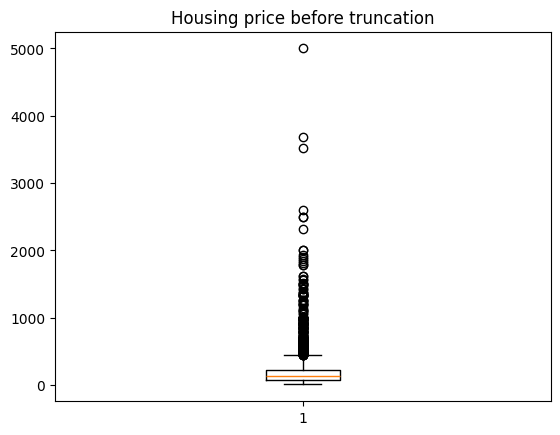

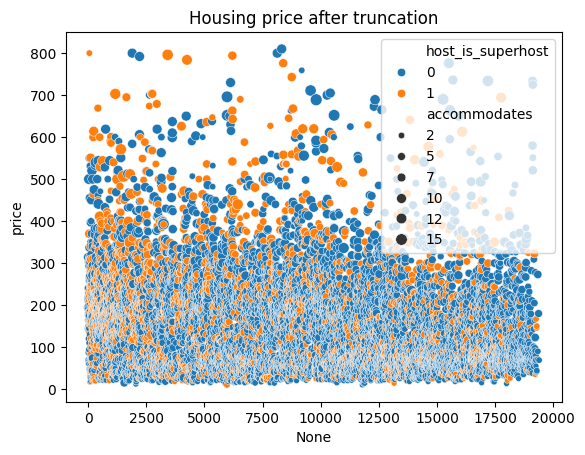

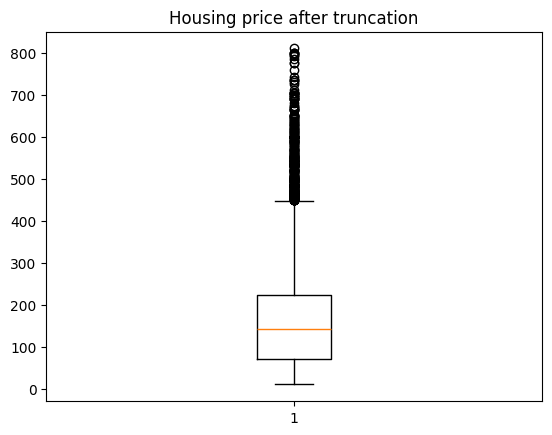

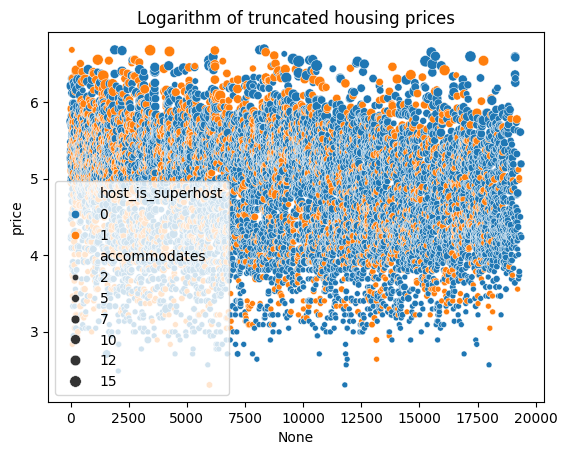

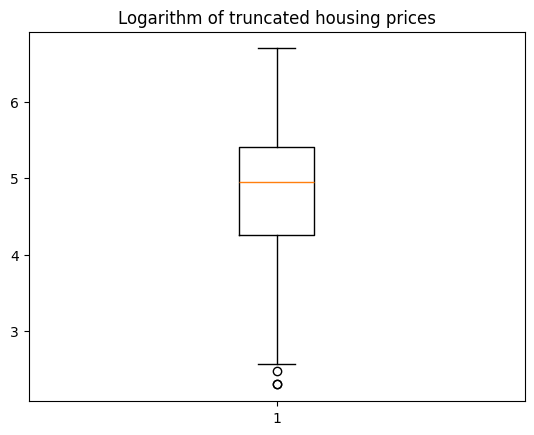

In [ ]:
# print price before truncation, after trunction and after logarithm
# before trunctation
sns.scatterplot(data = bnb_data, x = bnb_data.index, y = "price", hue = "host_is_superhost", size="accommodates")
plt.title("Housing price before truncation")
plt.show()
plt.boxplot(bnb_data["price"])
plt.title("Housing price before truncation")
plt.show()

# truncate price to be within 4 standard deviations
mean_price = bnb_data['price'].mean()
standard_dev = bnb_data['price'].std()
trunc_data = bnb_data[bnb_data['price'] <= 4*standard_dev + mean_price]

# after truncation
sns.scatterplot(data = trunc_data, x = trunc_data.index, y = "price", hue = "host_is_superhost", size="accommodates")
plt.title("Housing price after truncation")
plt.show()
plt.boxplot(trunc_data["price"])
plt.title("Housing price after truncation")
plt.show()

# transform price by taking the log
log_price_data = trunc_data.copy()
log_price_data["price"] = np.log(log_price_data["price"])

# after transformation
sns.scatterplot(data = log_price_data, x = log_price_data.index, y = "price", hue = "host_is_superhost", size="accommodates")
plt.title("Logarithm of truncated housing prices")
plt.show()
plt.boxplot(log_price_data["price"])
plt.title("Logarithm of truncated housing prices")
plt.show()

bnb_data = log_price_data.copy()


SPLIT DATA INTO TRAINING, VALIDATION AND TESTING

In [ ]:
# Shuffle the data (to ensure randomness)
pop_index_data = bnb_data.copy()

bnb_data = bnb_data.drop(["review_scores_rating", "availability_365", "id"], axis=1).sample(frac=1, random_state=42).reset_index(drop=True)

# Define split sizes
train_size = int(0.6 * len(bnb_data))
val_size = int(0.2 * len(bnb_data))
test_size = len(bnb_data) - train_size - val_size  # Ensures exact size without recalculating

# Split the data
train_data = bnb_data.iloc[:train_size]
val_data = bnb_data.iloc[train_size:train_size + val_size]
test_data = bnb_data.iloc[train_size + val_size:]

# Now you have:
# train_data -> 60% of the data for training
# val_data -> 20% of the data for validation
# test_data -> 20% of the data for testing

# Save to csv files so they don't change
train_data.to_csv("training_set.csv", index=False)
test_data.to_csv("test_set.csv", index=False)
val_data.to_csv("validation_set.csv", index=False)

REGRESSION WITH ALL VARIABLES(BASELINE MODEL)

In [ ]:
# linear regression
training_data = pd.read_csv("training_set.csv")
y = training_data["price"]
X = training_data.drop(["price"], axis = 1)
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     547.4
Date:                Thu, 12 Dec 2024   Prob (F-statistic):               0.00
Time:                        05:03:33   Log-Likelihood:                -5477.0
No. Observations:                7030   AIC:                         1.098e+04
Df Residuals:                    7016   BIC:                         1.108e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            67.2788     19.427      3.463      0.001      29.196     105.362
host_is_superhost                 0.0580      0.015      3.831      0.000       0.028       0.088
accommodates                      0.1526      0.009     17.086      0.000       0.135       0.170
bathrooms                        -0.0103      0.013     -0.806      0.420      -0.035       0.015
bedrooms                          0.0610      0.016      3.735      0.000       0.029       0.093
beds                             -0.0160      0.007     -2.385      0.017      -0.029      -0.003
amenities                         0.0027      0.001      5.265      0.000       0.002       0.004
latitude                         -1.5288      0.475     -3.217      0.001      -2.460      -0.597
longitude                         0.1562      0.383      0.408      0.683      -0.594       0.907
number_of_reviews             -7.656e-05   9.77e-05     -0.784      0.433      -0.000       0.000
reviews_per_month                 0.0447      0.004     10.461      0.000       0.036       0.053
room_neighborhood_interaction    -0.0218      0.001    -21.031      0.000      -0.024      -0.020
bedroom_density                  -0.3455      0.032    -10.840      0.000      -0.408      -0.283
age                            4.308e-05   7.68e-06      5.606      0.000     2.8e-05    5.81e-05
==============================================================================
Omnibus:                       40.363   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.038
Skew:                           0.027   Prob(JB):                     2.50e-13
Kurtosis:                       3.442   Cond. No.                     5.41e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.41e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

RMSE: 0.2781248430995141
R2_score: 0.5035588278384906


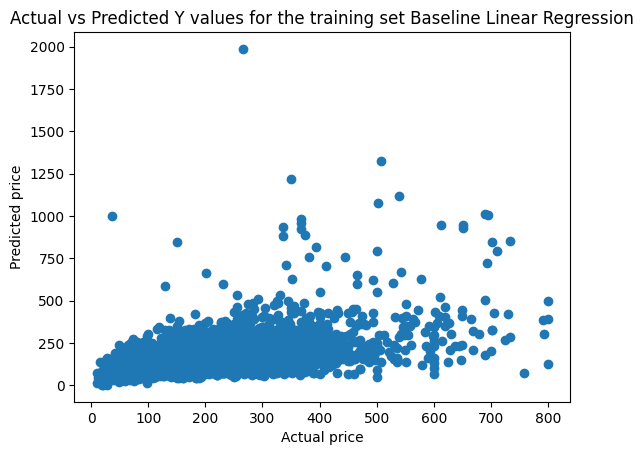

In [ ]:
# plot actual values vs predicted values on training data
plt.scatter(x = np.exp(y), y = np.exp(results.predict(X)))
plt.title("Actual vs Predicted Y values for the training set Baseline Linear Regression")
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
print(f"RMSE: {mean_squared_error(y, results.predict(X))}")
print(f"R2_score: {r2_score(y, results.predict(X))}")

RMSE: 0.2722776263236521
R2_score: 0.5047402440374713


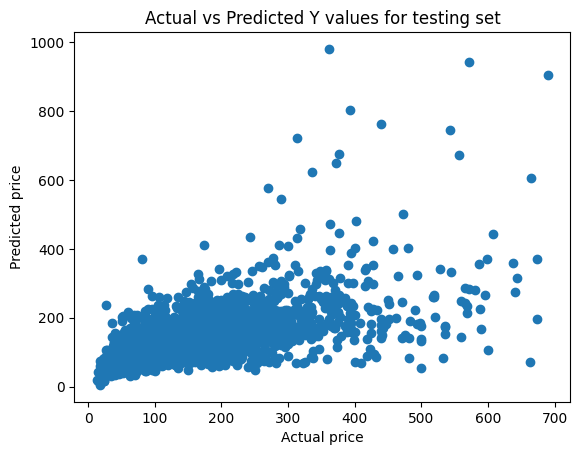

In [ ]:
# plot prediction values on test data
testing_data = pd.read_csv("test_set.csv")
y_test = testing_data["price"]
X_test = testing_data.drop(["price"], axis = 1)
X_test = sm.add_constant(X_test)
plt.scatter(x = np.exp(y_test), y = np.exp(results.predict(X_test)))
plt.title("Actual vs Predicted Y values for testing set")
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
r2_score(y_test, results.predict(X_test))
print(f"RMSE: {mean_squared_error(y_test, results.predict(X_test))}")
print(f"R2_score: {r2_score(y_test, results.predict(X_test))}")

RMSE: 0.2738806529961031
R2_score: 0.5098960667735617


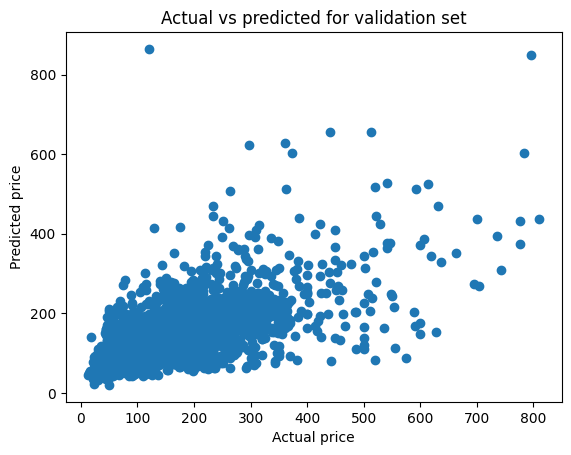

In [ ]:
# plot prediction values on validation data
val_data = pd.read_csv("validation_set.csv")
y_val = val_data["price"]
X_val = val_data.drop(["price"], axis = 1)
X_val = sm.add_constant(X_val)
plt.scatter(x = np.exp(y_val), y = np.exp(results.predict(X_val)))
plt.title("Actual vs predicted for validation set")
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
print(f"RMSE: {mean_squared_error(y_val, results.predict(X_val))}")
print(f"R2_score: {r2_score(y_val, results.predict(X_val))}")

CORRELATION

In [ ]:
# Pearson Correlation
training_data_corr = np.round(training_data.corr(method="pearson"), 3)
training_data_corr

,host_is_superhost,accommodates,bathrooms,bedrooms,beds,amenities,latitude,longitude,price,number_of_reviews,reviews_per_month,room_neighborhood_interaction,bedroom_density,age
host_is_superhost,1.000,0.005,0.025,0.019,-0.008,0.314,0.005,-0.002,0.092,0.226,0.103,-0.049,0.003,0.226
accommodates,0.005,1.000,0.481,0.786,0.825,0.223,0.031,-0.021,0.638,0.149,0.015,-0.498,-0.280,0.226
bathrooms,0.025,0.481,1.000,0.527,0.445,0.088,-0.008,-0.017,0.244,0.045,0.004,-0.119,0.101,0.062
bedrooms,0.019,0.786,0.527,1.000,0.758,0.195,0.033,-0.038,0.450,0.088,-0.023,-0.384,0.241,0.159
beds,-0.008,0.825,0.445,0.758,1.000,0.198,0.037,-0.024,0.487,0.137,0.000,-0.361,-0.065,0.224
amenities,0.314,0.223,0.088,0.195,0.198,1.000,0.035,-0.019,0.250,0.215,0.069,-0.231,-0.077,0.244
latitude,0.005,0.031,-0.008,0.033,0.037,0.035,1.000,0.295,-0.031,-0.016,-0.021,0.068,0.017,0.008
longitude,-0.002,-0.021,-0.017,-0.038,-0.024,-0.019,0.295,1.000,0.000,-0.020,0.005,-0.066,-0.015,-0.011
price,0.092,0.638,0.244,0.450,0.487,0.250,-0.031,0.000,1.000,0.229,0.125,-0.511,-0.335,0.243
number_of_reviews,0.226,0.149,0.045,0.088,0.137,0.215,-0.016,-0.020,0.229,1.000,0.614,-0.084,-0.080,0.593


<Axes: title={'center': 'Heatmap for Feature Pearson Correlation'}>

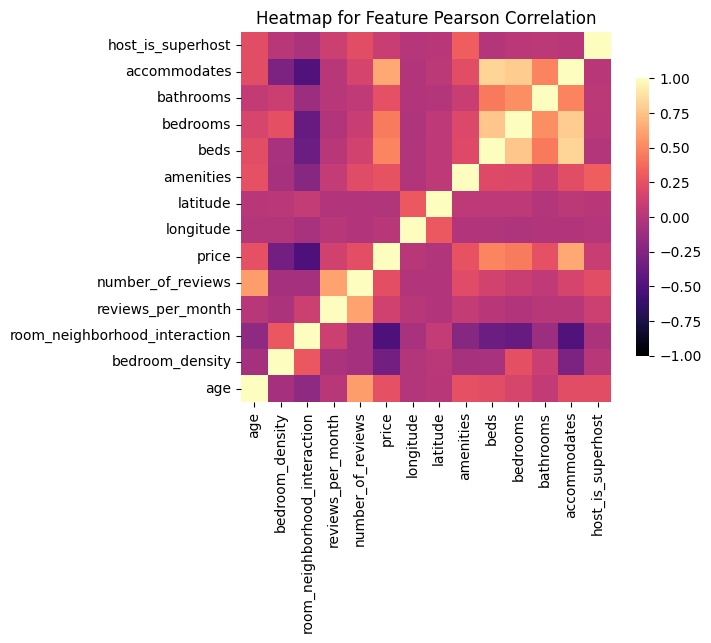

In [ ]:
# Plot heatmap of correlations among features
plt.title("Heatmap for Feature Pearson Correlation")
sns.heatmap(training_data_corr[training_data_corr.columns[::-1]], cmap="magma", square=True, cbar_kws={"shrink": .75}, vmin=-1, vmax=1, )

REGRESSION WITH ONLY SOME INDEPENDENT VARIABLES

In [ ]:
# linear regression
dropped_columns = ["beds", "bedroom_density", "host_is_superhost", "bedrooms", "price"]
training_data = pd.read_csv("training_set.csv")
y_train = training_data["price"]
X_train = training_data.drop(dropped_columns, axis = 1)
X_train = sm.add_constant(X_train)
results = sm.OLS(y_train, X_train).fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     746.3
Date:                Thu, 12 Dec 2024   Prob (F-statistic):               0.00
Time:                        05:03:36   Log-Likelihood:                -5579.0
No. Observations:                7030   AIC:                         1.118e+04
Df Residuals:                    7020   BIC:                         1.125e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            71.0251     19.694      3.607      0.000      32.420     109.630
accommodates                      0.1793      0.004     43.255      0.000       0.171       0.187
bathrooms                        -0.0455      0.012     -3.667      0.000      -0.070      -0.021
amenities                         0.0032      0.001      6.458      0.000       0.002       0.004
latitude                         -1.6228      0.482     -3.369      0.001      -2.567      -0.678
longitude                         0.1512      0.388      0.390      0.697      -0.609       0.911
number_of_reviews             -8.847e-05   9.89e-05     -0.894      0.371      -0.000       0.000
reviews_per_month                 0.0489      0.004     11.321      0.000       0.040       0.057
room_neighborhood_interaction    -0.0247      0.001    -24.382      0.000      -0.027      -0.023
age                            4.538e-05   7.74e-06      5.862      0.000    3.02e-05    6.06e-05
==============================================================================
Omnibus:                       57.929   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.996
Skew:                           0.027   Prob(JB):                     1.74e-20
Kurtosis:                       3.555   Cond. No.                     5.40e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.4e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

RMSE: 0.286306339842378
R2_score: 0.4889551995261153


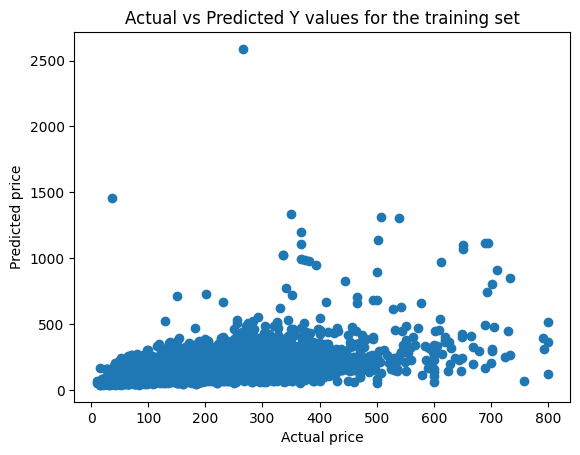

In [ ]:
# plot actual values vs predicted values on training data
plt.scatter(x = np.exp(y_train), y = np.exp(results.predict(X_train)))
plt.title("Actual vs Predicted Y values for the training set")
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
print(f"RMSE: {mean_squared_error(y_train, results.predict(X_train))}")
print(f"R2_score: {r2_score(y_train, results.predict(X_train))}")

RMSE: 0.28439548039660284
R2_score: 0.4826984570129831


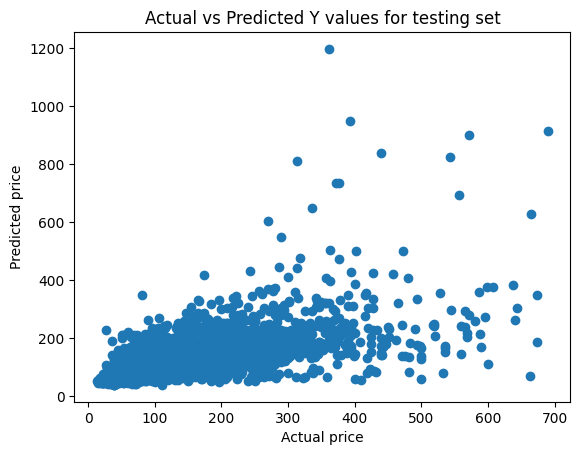

In [ ]:
# plot prediction values on test data
testing_data = pd.read_csv("test_set.csv")
y_test = testing_data["price"]
X_test = testing_data.drop(dropped_columns, axis = 1)
X_test = sm.add_constant(X_test)
plt.scatter(x = np.exp(y_test), y = np.exp(results.predict(X_test)))
plt.title("Actual vs Predicted Y values for testing set")
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
r2_score(y_test, results.predict(X_test))
print(f"RMSE: {mean_squared_error(y_test, results.predict(X_test))}")
print(f"R2_score: {r2_score(y_test, results.predict(X_test))}")

RMSE: 0.28433719490205706
R2_score: 0.49118429483935344


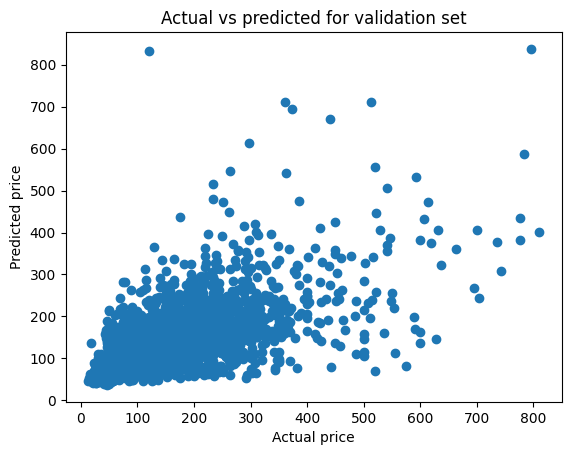

In [ ]:
# plot prediction values on validation data
val_data = pd.read_csv("validation_set.csv")
y_val = val_data["price"]
X_val = val_data.drop(dropped_columns, axis = 1)
X_val = sm.add_constant(X_val)
plt.scatter(x = np.exp(y_val), y = np.exp(results.predict(X_val)))
plt.title("Actual vs predicted for validation set")
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
print(f"RMSE: {mean_squared_error(y_val, results.predict(X_val))}")
print(f"R2_score: {r2_score(y_val, results.predict(X_val))}")

RANDOM FOREST MODEL




In [ ]:
# Train a Random Forest Regression
y_train = training_data["price"]
X_train = training_data.drop(["price"], axis = 1)

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Regression Mean Squared Error: 0.02
R2_Score: 0.96


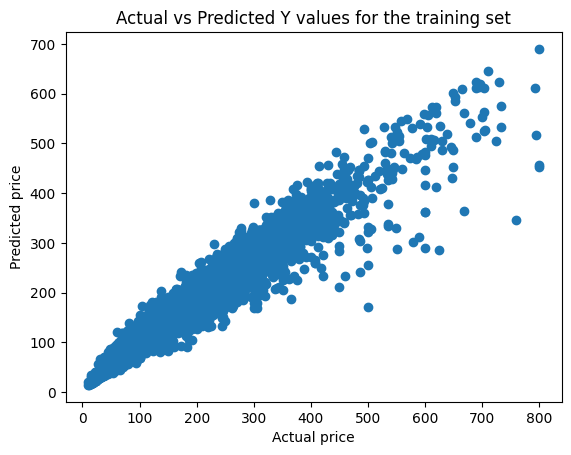

In [ ]:
# plot actual values vs predicted values on training data
y_pred = rf_regressor.predict(X_train)
plt.scatter(x = np.exp(y_train), y = np.exp(y_pred))
plt.title("Actual vs Predicted Y values for the training set")
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
print(f"Regression Mean Squared Error: {mse:.2f}")
print(f"R2_Score: {r2:.2f}")

                          Feature  Importance
1                    accommodates    0.457968
8               number_of_reviews    0.085144
6                        latitude    0.082640
9               reviews_per_month    0.069901
10  room_neighborhood_interaction    0.064778
7                       longitude    0.054623
12                            age    0.053882
5                       amenities    0.047932
2                       bathrooms    0.037862
4                            beds    0.016442
11                bedroom_density    0.015013
3                        bedrooms    0.007242
0               host_is_superhost    0.006573


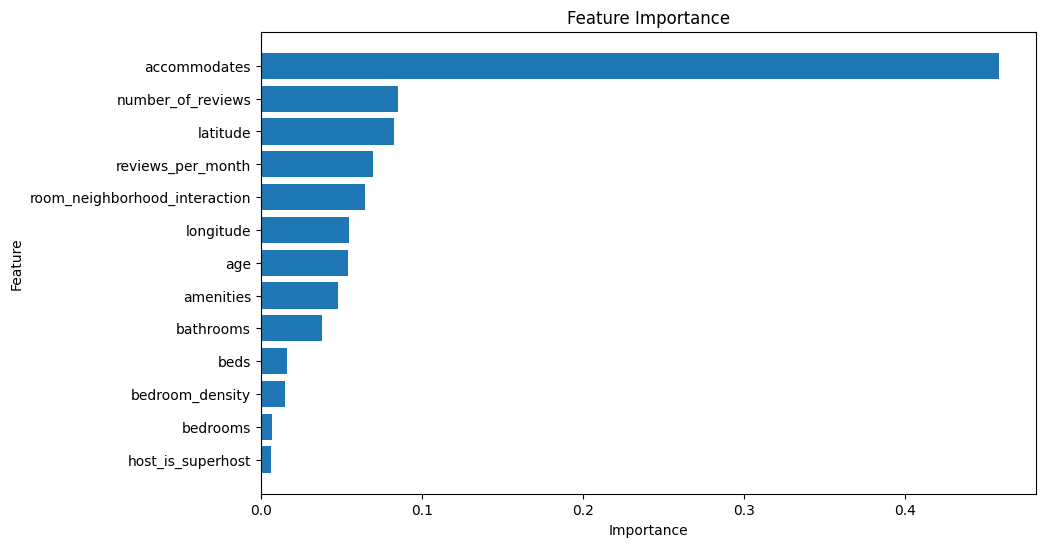

In [ ]:
# Step 1: Extract feature importance
feature_importances = rf_regressor.feature_importances_

# Step 2: Map to feature names
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Step 3: Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display top features
print(importance_df)

# Step 4: Optional - Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

RMSE: 0.17335887021321952
R2_score: 0.6846686489998957


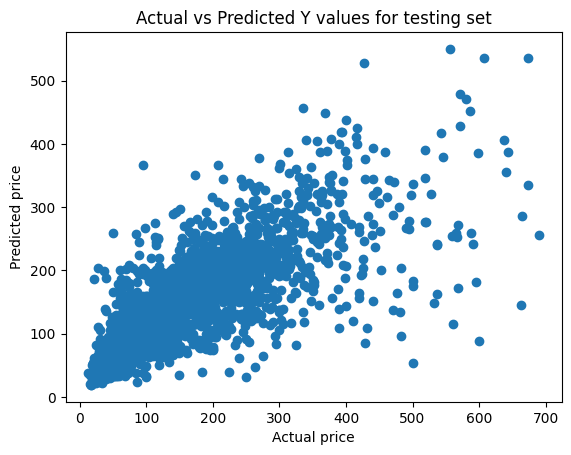

In [ ]:
# plot prediction values on test data
testing_data = pd.read_csv("test_set.csv")
y_test = testing_data["price"]
X_test = testing_data.drop(["price"], axis = 1)
y_test_pred = rf_regressor.predict(X_test)
plt.scatter(x = np.exp(y_test), y = np.exp(y_test_pred))
plt.title("Actual vs Predicted Y values for testing set")
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
print(f"RMSE: {mean_squared_error(y_test, rf_regressor.predict(X_test))}")
print(f"R2_score: {r2_score(y_test, rf_regressor.predict(X_test))}")

RMSE: 0.1721957226690257
R2_score: 0.691859209324803


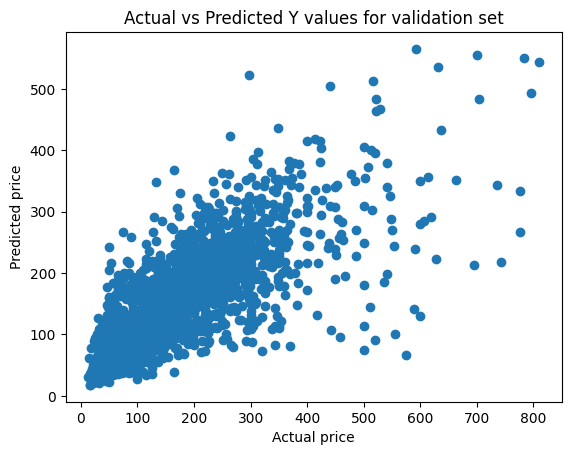

In [ ]:
# plot prediction values on val data
val_data = pd.read_csv("validation_set.csv")
y_val = val_data["price"]
X_val = val_data.drop(["price"], axis = 1)
y_val_pred = rf_regressor.predict(X_val)
plt.scatter(x = np.exp(y_val), y = np.exp(y_val_pred))
plt.title("Actual vs Predicted Y values for validation set")
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
print(f"RMSE: {mean_squared_error(y_val, rf_regressor.predict(X_val))}")
print(f"R2_score: {r2_score(y_val, rf_regressor.predict(X_val))}")

POPULARITY RANKING

In [ ]:
pop_index_data.isna().sum()

,0
host_is_superhost,0
accommodates,0
bathrooms,0
bedrooms,0
beds,0
amenities,0
latitude,0
longitude,0
price,0
number_of_reviews,0


In [ ]:
# Relevant features
features = ['review_scores_rating', 'number_of_reviews', 'reviews_per_month', 'availability_365']

# Drop rows with missing values in relevant columns
pop_index_data = pop_index_data.dropna(subset=features)

# Normalize features
scaler = MinMaxScaler()
pop_index_data_normalized = pd.DataFrame(scaler.fit_transform(pop_index_data[features]), columns=features)

# Assign weights to features
weights = {
    'review_scores_rating': 0.4,
    'number_of_reviews': 0.3,
    'reviews_per_month': 0.2,
    'availability_365': 0.1
}

# Calculate the weighted sum for the popularity index
pop_index_data['popularity_index'] = (
    pop_index_data_normalized['review_scores_rating'] * weights['review_scores_rating'] +
    pop_index_data_normalized['number_of_reviews'] * weights['number_of_reviews'] +
    pop_index_data_normalized['reviews_per_month'] * weights['reviews_per_month'] +
    pop_index_data_normalized['availability_365'] * weights['availability_365']
)

# Sort by popularity index
pop_index_data_sorted = pop_index_data.sort_values(by='popularity_index', ascending=False)

# Display top 5 listings based on popularity index
pop_index_data_sorted[['id', 'popularity_index', 'review_scores_rating', 'number_of_reviews', 'reviews_per_month', 'availability_365']].head()

,id,popularity_index,review_scores_rating,number_of_reviews,reviews_per_month,availability_365
8302,45969832,0.700922,4.80,20,0.45,75
3635,18918162,0.693920,4.86,28,0.38,65
5441,29536130,0.660476,4.92,205,2.90,221
3070,16307165,0.645309,5.00,1,0.04,314
419,1074936,0.630173,4.48,42,0.37,333


Descriptive Statistics of Popularity Index:
count    7590.000000
mean        0.427192
std         0.061322
min         0.000161
25%         0.401682
50%         0.433913
75%         0.466923
max         0.700922
Name: popularity_index, dtype: float64
Correlation Matrix:
                      review_scores_rating  number_of_reviews  \
review_scores_rating              1.000000           0.123387   
number_of_reviews                 0.123387           1.000000   
reviews_per_month                 0.091545           0.575700   
availability_365                 -0.063920          -0.009656   
popularity_index                  0.010645           0.086091   

                      reviews_per_month  availability_365  popularity_index  
review_scores_rating           0.091545         -0.063920          0.010645  
number_of_reviews              0.575700         -0.009656          0.086091  
reviews_per_month              1.000000         -0.058087         -0.003812  
availability_365          

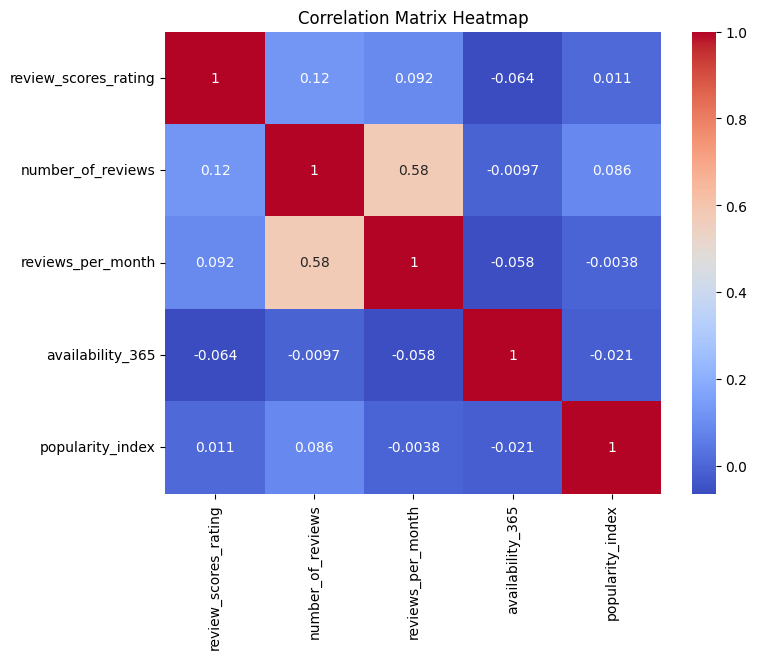

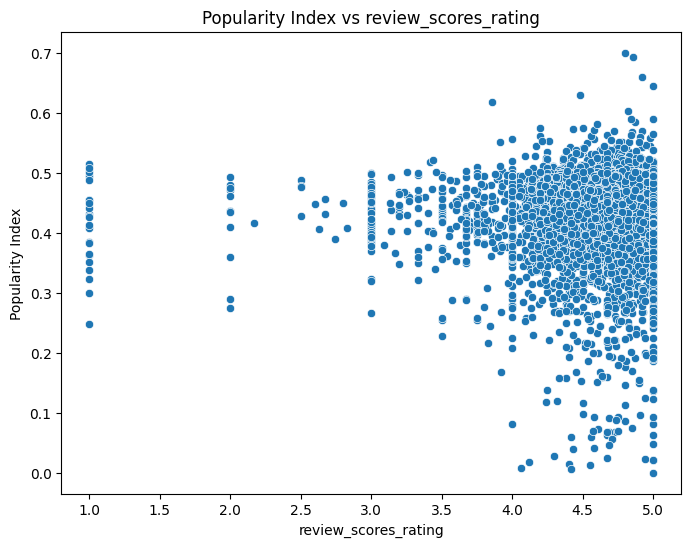

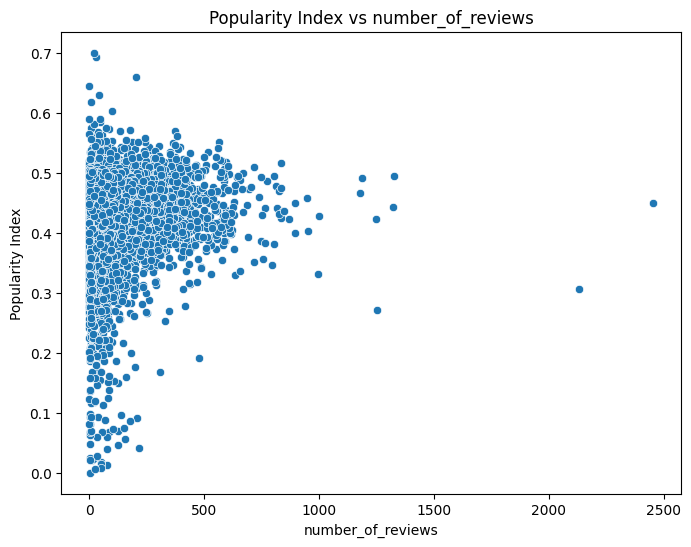

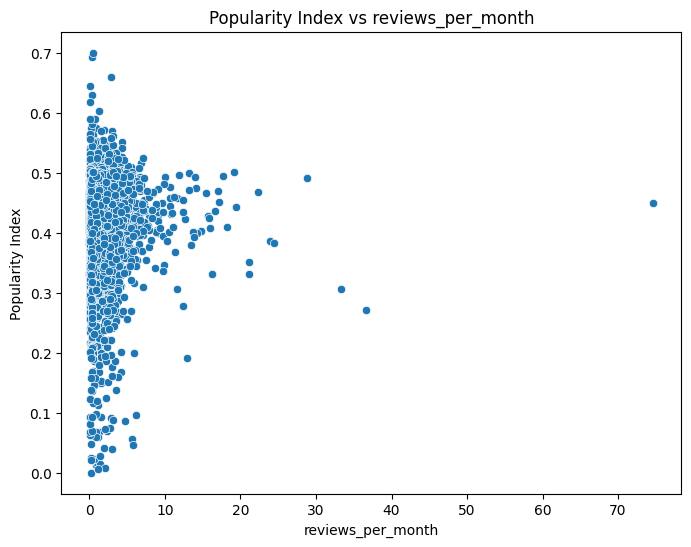

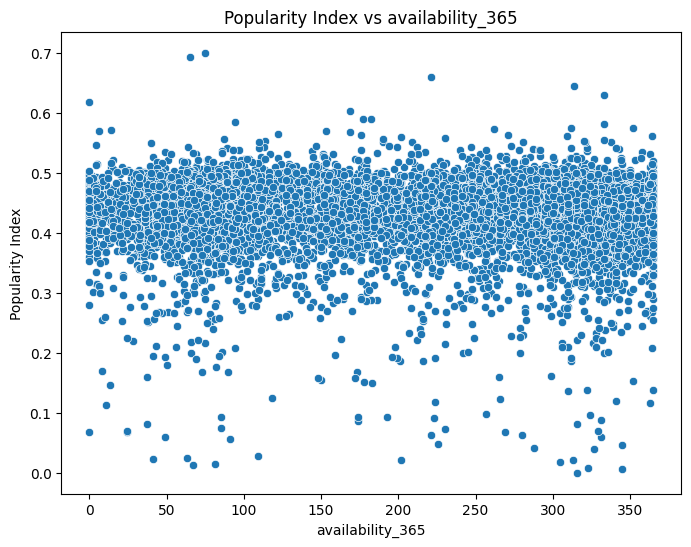

Number of common listings in top 10 by index and rating: 0
Common Listing IDs: set()
Descriptive Statistics of Adjusted Popularity Index:
count    7590.000000
mean        0.357987
std         0.053403
min         0.000161
25%         0.340285
50%         0.364450
75%         0.386618
max         0.660789
Name: popularity_index_adjusted, dtype: float64


In [ ]:
# --- Evaluation Steps ---

# 1. Descriptive Statistics
print("Descriptive Statistics of Popularity Index:")
print(pop_index_data['popularity_index'].describe())

# 2. Correlation Analysis
correlation_matrix = pop_index_data[features + ['popularity_index']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Visualizing Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

# 3. Visual Inspection
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=pop_index_data[feature], y=pop_index_data['popularity_index'])
    plt.title(f'Popularity Index vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Popularity Index')
    plt.show()

# 4. index Comparison
# Top 10 listings by popularity index
top_by_index = pop_index_data.sort_values(by='popularity_index', ascending=False).head(10)
# Top 10 listings by review_scores_rating
top_by_rating = pop_index_data.sort_values(by='review_scores_rating', ascending=False).head(10)

# Compare the two sets
common_listings = set(top_by_index['id']).intersection(set(top_by_rating['id']))
print(f"Number of common listings in top 10 by index and rating: {len(common_listings)}")
print(f"Common Listing IDs: {common_listings}")

# 5. Adjust Weights and Recalculate
# Based on findings, adjust weights if necessary
# Example: Increase weight for 'number_of_reviews' and decrease 'availability_365'
adjusted_weights = {
    'review_scores_rating': 0.35,
    'number_of_reviews': 0.4,
    'reviews_per_month': 0.2,
    'availability_365': 0.05
}

# Recalculate popularity index
pop_index_data['popularity_index_adjusted'] = (
    pop_index_data_normalized['review_scores_rating'] * adjusted_weights['review_scores_rating'] +
    pop_index_data_normalized['number_of_reviews'] * adjusted_weights['number_of_reviews'] +
    pop_index_data_normalized['reviews_per_month'] * adjusted_weights['reviews_per_month'] +
    pop_index_data_normalized['availability_365'] * adjusted_weights['availability_365']
)

# Compare the new index
print("Descriptive Statistics of Adjusted Popularity Index:")
print(pop_index_data['popularity_index_adjusted'].describe())